# Preprocessing 

In [2]:
# Importing libraries
import pandas as pd
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from geopy.distance import geodesic
import geopandas as gpd

C:\Users\hp\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('train.csv')

In [3]:
def calculate_distance(row):
    return geodesic(row['pickup'], row['dropoff']).kilometers

In [4]:
def preprocess(df):
    
    # Setting id as the index
    df.set_index('id', inplace = True)
    
    # Creating pickup and dropoff tuples to pass to the distance function 
    df['pickup'] = df.apply(lambda row: (row['pickup_latitude'], row['pickup_longitude']), axis=1)
    df['dropoff'] = df.apply(lambda row: (row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    df['distance_km'] = df.apply(calculate_distance, axis=1)
    
    # Changing trip duration from seconds to minutes
    df['trip_duration'] = df['trip_duration']/60
    
    # Calculating the minimum duration possible given the highest speed
    df['min_duration'] = (df['distance_km']/137) * 60
    
    # Formatting the pickup and dropoff datetimes into datetime format
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
    
    # Extracting Month, Day, Hour, Day of week and Time of day from the pickup datetime
    df['Month'] = df['pickup_datetime'].dt.month
    df['Day'] = df['pickup_datetime'].dt.day
    df['Hour'] = df['pickup_datetime'].dt.hour
    df['DayOfWeek'] = df['pickup_datetime'].dt.dayofweek
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['DayOfWeek'] = df['DayOfWeek'].map(lambda x: day_names[x])
    bins = [0, 6, 12, 18, 24]
    labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    df['TimeOfDay'] = pd.cut(df['pickup_datetime'].dt.hour, bins=bins, labels=labels, include_lowest=True)

    # Changing integer type columns into categorical
    df['vendor_id'] = df['vendor_id'].astype('category')
    df['passenger_count'] = df['passenger_count'].astype('category')
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')
    df['Month'] = df['Month'].astype('category')
    df['Day'] = df['Day'].astype('category')
    df['DayOfWeek'] = df['DayOfWeek'].astype('category')
    df['Hour'] = df['Hour'].astype('category')
    df['TimeOfDay'] = df['TimeOfDay'].astype('category')
    
    # Dropping unnecessary columns
    #df = df[['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'distance_km','Month','Day', 'DayOfWeek', 'TimeOfDay','Hour']]
    
    return df

In [5]:
df = preprocess(df)

In [6]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay
id,,,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,7.583333,"(40.76793670654297, -73.98215484619139)","(40.765602111816406, -73.96463012695312)",1.502172,0.657885,3,14,17,Monday,Afternoon
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,11.050000,"(40.738563537597656, -73.98041534423827)","(40.731151580810554, -73.99948120117188)",1.808660,0.792114,6,12,0,Sunday,Night
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,35.400000,"(40.763938903808594, -73.97902679443358)","(40.710086822509766, -74.00533294677734)",6.379687,2.794024,1,19,11,Tuesday,Morning
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,7.150000,"(40.719970703125, -74.01004028320312)","(40.70671844482422, -74.01226806640625)",1.483632,0.649766,4,6,19,Wednesday,Evening
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,7.250000,"(40.79320907592773, -73.97305297851561)","(40.782520294189446, -73.9729232788086)",1.187038,0.519871,3,26,13,Saturday,Afternoon


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1458644 non-null  category      
 1   pickup_datetime     1458644 non-null  datetime64[ns]
 2   dropoff_datetime    1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  category      
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  category      
 9   trip_duration       1458644 non-null  float64       
 10  pickup              1458644 non-null  object        
 11  dropoff             1458644 non-null  object        
 12  distance_km         1458644 non-null  float64       
 13  min_dur

#### Checking if pickup and dropoff locations are in NYC

In [8]:
nyc_boundary = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')

In [9]:
# Create GeoDataFrame from DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude))

# Initialize a list to store the point-in-polygon results
is_in_nyc_list = []

# Iterate through each polygon in the NYC boundary data
for polygon in nyc_boundary.geometry:
    # Perform point-in-polygon check for each point
    is_in_polygon = gdf.geometry.within(polygon)
    is_in_nyc_list.append(is_in_polygon)

# Create a DataFrame from the list of boolean arrays and check if any is True
is_in_nyc_df = pd.DataFrame(is_in_nyc_list).any(axis=0)

# Add the results to the original GeoDataFrame
gdf['pickup_is_in_nyc'] = is_in_nyc_df

df_pickup = pd.DataFrame(gdf)

In [10]:
df_pickup.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,geometry,pickup_is_in_nyc
id,,,,,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,7.583333,...,"(40.765602111816406, -73.96463012695312)",1.502172,0.657885,3,14,17,Monday,Afternoon,POINT (-73.98215 40.76794),True
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,11.050000,...,"(40.731151580810554, -73.99948120117188)",1.808660,0.792114,6,12,0,Sunday,Night,POINT (-73.98042 40.73856),True
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,35.400000,...,"(40.710086822509766, -74.00533294677734)",6.379687,2.794024,1,19,11,Tuesday,Morning,POINT (-73.97903 40.76394),True
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,7.150000,...,"(40.70671844482422, -74.01226806640625)",1.483632,0.649766,4,6,19,Wednesday,Evening,POINT (-74.01004 40.71997),True
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,7.250000,...,"(40.782520294189446, -73.9729232788086)",1.187038,0.519871,3,26,13,Saturday,Afternoon,POINT (-73.97305 40.79321),True


In [11]:
# Create GeoDataFrame from DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude))

# Initialize a list to store the point-in-polygon results
is_in_nyc_list = []

# Iterate through each polygon in the NYC boundary data
for polygon in nyc_boundary.geometry:
    # Perform point-in-polygon check for each point
    is_in_polygon = gdf.geometry.within(polygon)
    is_in_nyc_list.append(is_in_polygon)

# Create a DataFrame from the list of boolean arrays and check if any is True
is_in_nyc_df = pd.DataFrame(is_in_nyc_list).any(axis=0)

# Add the results to the original GeoDataFrame
gdf['dropoff_is_in_nyc'] = is_in_nyc_df

df_temp = pd.DataFrame(gdf)

In [12]:
df_temp.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,geometry,dropoff_is_in_nyc
id,,,,,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,7.583333,...,"(40.765602111816406, -73.96463012695312)",1.502172,0.657885,3,14,17,Monday,Afternoon,POINT (-73.96463 40.76560),True
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,11.050000,...,"(40.731151580810554, -73.99948120117188)",1.808660,0.792114,6,12,0,Sunday,Night,POINT (-73.99948 40.73115),True
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,35.400000,...,"(40.710086822509766, -74.00533294677734)",6.379687,2.794024,1,19,11,Tuesday,Morning,POINT (-74.00533 40.71009),True
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,7.150000,...,"(40.70671844482422, -74.01226806640625)",1.483632,0.649766,4,6,19,Wednesday,Evening,POINT (-74.01227 40.70672),True
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,7.250000,...,"(40.782520294189446, -73.9729232788086)",1.187038,0.519871,3,26,13,Saturday,Afternoon,POINT (-73.97292 40.78252),True


In [13]:
df_temp['pickup_is_in_nyc'] = df_pickup['pickup_is_in_nyc']

In [14]:
df_temp['pickup_is_in_nyc'].value_counts()

pickup_is_in_nyc
True     1455459
False       3185
Name: count, dtype: int64

In [15]:
df_temp['dropoff_is_in_nyc'].value_counts()

dropoff_is_in_nyc
True     1450727
False       7917
Name: count, dtype: int64

#### Dropping unnecessary columns

In [16]:
df_tempp = df_temp.drop(columns=['pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude',
                      'dropoff_latitude', 'geometry' ])

In [17]:
df_tempp.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
id,,,,,,,,,,,,,,,
id2875421,2,1,N,7.583333,"(40.76793670654297, -73.98215484619139)","(40.765602111816406, -73.96463012695312)",1.502172,0.657885,3,14,17,Monday,Afternoon,True,True
id2377394,1,1,N,11.050000,"(40.738563537597656, -73.98041534423827)","(40.731151580810554, -73.99948120117188)",1.808660,0.792114,6,12,0,Sunday,Night,True,True
id3858529,2,1,N,35.400000,"(40.763938903808594, -73.97902679443358)","(40.710086822509766, -74.00533294677734)",6.379687,2.794024,1,19,11,Tuesday,Morning,True,True
id3504673,2,1,N,7.150000,"(40.719970703125, -74.01004028320312)","(40.70671844482422, -74.01226806640625)",1.483632,0.649766,4,6,19,Wednesday,Evening,True,True
id2181028,2,1,N,7.250000,"(40.79320907592773, -73.97305297851561)","(40.782520294189446, -73.9729232788086)",1.187038,0.519871,3,26,13,Saturday,Afternoon,True,True


In [18]:
df_tempp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   vendor_id           1458644 non-null  category
 1   passenger_count     1458644 non-null  category
 2   store_and_fwd_flag  1458644 non-null  category
 3   trip_duration       1458644 non-null  float64 
 4   pickup              1458644 non-null  object  
 5   dropoff             1458644 non-null  object  
 6   distance_km         1458644 non-null  float64 
 7   min_duration        1458644 non-null  float64 
 8   Month               1458644 non-null  category
 9   Day                 1458644 non-null  category
 10  Hour                1458644 non-null  category
 11  DayOfWeek           1458644 non-null  category
 12  TimeOfDay           1458644 non-null  category
 13  dropoff_is_in_nyc   1458644 non-null  bool    
 14  pickup_is_in_nyc    1458644 non-null  bool   

#### Dropping records where the trip duration is less than the min duration

In [19]:
df_tempp[df_tempp['trip_duration'] < df_tempp['min_duration']]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
id,,,,,,,,,,,,,,,
id0729156,2,3,N,0.033333,"(40.716175079345696, -73.82765960693358)","(40.71145248413086, -73.82211303710938)",0.703342,0.308033,6,23,13,Thursday,Afternoon,True,True
id3468323,1,1,N,5.916667,"(40.88294219970703, -73.88119506835938)","(40.76248550415039, -73.96514129638672)",15.135680,6.628765,6,27,18,Monday,Afternoon,True,True
id0508130,2,3,N,0.183333,"(40.74740982055664, -74.00066375732422)","(40.74394989013672, -74.00318908691406)",0.439450,0.192460,4,30,0,Saturday,Night,True,True
id1656254,2,1,N,0.266667,"(40.65135955810546, -73.80552673339844)","(40.66162872314453, -73.80422973632812)",1.145626,0.501734,1,18,0,Monday,Night,True,True
id0456393,1,1,N,4.416667,"(40.74800491333008, -73.97966766357422)","(40.68331527709961, -73.86509704589844)",12.054945,5.279538,4,27,6,Wednesday,Night,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id3628988,1,1,N,9.133333,"(41.586273193359375, -79.56973266601561)","(42.09018325805664, -80.35543060302734)",85.972969,37.652395,5,5,18,Thursday,Afternoon,False,False
id2427976,2,1,N,0.116667,"(40.75566101074219, -73.98374938964845)","(40.753223419189446, -73.98115539550781)",0.348223,0.152506,2,7,15,Sunday,Afternoon,True,True
id3141426,2,1,N,0.083333,"(40.73060989379882, -73.87471771240233)","(40.73286819458008, -73.867431640625)",0.664623,0.291076,5,6,18,Friday,Afternoon,True,True


In [20]:
df_tempp = df_tempp[df_tempp['trip_duration'] >= df_tempp['min_duration']]

#### Setting the trip duration to zero when the distance is zero

In [21]:
df_tempp.loc[df_tempp['distance_km'] == 0, 'trip_duration'] = 0

#### Removing any records where the trip duration is longer than a day (1440 minutes)

In [22]:
df_tempp['trip_duration'].max()

58771.36666666667

In [25]:
len(df_tempp[df_tempp['trip_duration'] >= 1440])

4

In [26]:
df_tempp = df_tempp[df_tempp['trip_duration'] < 1440]

In [27]:
df_tempp[(df_tempp['dropoff_is_in_nyc'] == False) | (df_tempp['pickup_is_in_nyc'] == False)]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
id,,,,,,,,,,,,,,,
id2358953,2,1,N,35.266667,"(40.773738861083984, -73.87081909179686)","(41.0178108215332, -73.85749816894531)",27.127888,11.880827,6,27,0,Monday,Night,False,True
id1935437,2,1,N,27.750000,"(40.75724029541016, -73.97586059570312)","(40.690948486328125, -74.17759704589844)",18.565594,8.130917,4,24,9,Sunday,Morning,False,True
id1445390,2,3,N,17.250000,"(40.78195190429688, -73.96012115478516)","(40.75503921508789, -73.97196960449217)",3.151613,1.380269,1,19,8,Tuesday,Morning,True,False
id0610780,1,1,N,8.383333,"(40.78181838989258, -73.9755630493164)","(40.76074981689453, -73.9755859375)",2.339655,1.024666,6,10,8,Friday,Morning,False,True
id0320308,2,1,N,9.983333,"(40.78990173339844, -73.9543228149414)","(40.77642059326172, -73.954345703125)",1.497078,0.655655,5,10,19,Tuesday,Evening,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id1191995,1,2,N,0.400000,"(40.78235626220703, -74.00644683837889)","(40.78233337402344, -74.00633239746092)",0.009989,0.004375,4,27,19,Wednesday,Evening,False,False
id0792740,1,2,N,11.966667,"(40.76810836791992, -73.9824676513672)","(40.762710571289055, -73.981201171875)",0.608885,0.266665,1,1,19,Friday,Evening,True,False
id2824253,1,1,N,54.683333,"(40.80053329467773, -73.96192169189453)","(40.69112396240234, -74.17726898193358)",21.872580,9.579232,3,3,8,Thursday,Morning,False,True


In [28]:
df_tempp[(df_tempp['dropoff_is_in_nyc'] == False) & (df_tempp['pickup_is_in_nyc'] == False)]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
id,,,,,,,,,,,,,,,
id0753277,1,1,N,0.000000,"(40.81685256958008, -74.20985412597656)","(40.81685256958008, -74.20985412597656)",0.000000,0.000000,1,27,22,Wednesday,Evening,False,False
id1606138,2,2,N,0.000000,"(40.69028091430664, -74.1777801513672)","(40.69028091430664, -74.1777801513672)",0.000000,0.000000,4,27,15,Wednesday,Afternoon,False,False
id0474312,2,1,N,7.333333,"(40.75495147705078, -73.95172882080078)","(40.73802947998047, -73.96842193603516)",2.349244,1.028866,5,29,6,Sunday,Night,False,False
id1174525,2,1,N,0.150000,"(40.77859878540039, -74.01520538330078)","(40.778602600097656, -74.01514434814453)",0.005170,0.002264,6,25,8,Saturday,Morning,False,False
id0688948,1,1,N,0.000000,"(40.83649444580078, -74.16180419921875)","(40.83649444580078, -74.16180419921875)",0.000000,0.000000,4,14,20,Thursday,Evening,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id0938504,2,1,N,0.000000,"(40.71918869018555, -74.35665893554686)","(40.71918869018555, -74.35665893554686)",0.000000,0.000000,6,21,22,Tuesday,Evening,False,False
id3502840,2,1,N,0.000000,"(40.87575149536133, -74.02178955078125)","(40.87575149536133, -74.02178955078125)",0.000000,0.000000,1,16,18,Saturday,Afternoon,False,False
id1367595,2,1,N,36.716667,"(40.78998565673828, -74.0471420288086)","(41.11236572265625, -74.01087188720702)",35.931271,15.736323,4,9,1,Saturday,Night,False,False


In [71]:
df_tempp.to_csv('all.csv', index=False)

In [3]:
df_tempp = pd.read_csv('all.csv')

In [5]:
df_tempp.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
0,2,1,N,7.583333,"(40.76793670654297, -73.98215484619139)","(40.765602111816406, -73.96463012695312)",1.502172,0.657885,3,14,17,Monday,Afternoon,True,True
1,1,1,N,11.050000,"(40.738563537597656, -73.98041534423827)","(40.731151580810554, -73.99948120117188)",1.808660,0.792114,6,12,0,Sunday,Night,True,True
2,2,1,N,35.400000,"(40.763938903808594, -73.97902679443358)","(40.710086822509766, -74.00533294677734)",6.379687,2.794024,1,19,11,Tuesday,Morning,True,True
3,2,1,N,7.150000,"(40.719970703125, -74.01004028320312)","(40.70671844482422, -74.01226806640625)",1.483632,0.649766,4,6,19,Wednesday,Evening,True,True
4,2,1,N,7.250000,"(40.79320907592773, -73.97305297851561)","(40.782520294189446, -73.9729232788086)",1.187038,0.519871,3,26,13,Saturday,Afternoon,True,True


In [7]:
df_tempp['trip_duration'] = df_tempp['trip_duration']*60

In [8]:
df_tempp.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
0,2,1,N,455.0,"(40.76793670654297, -73.98215484619139)","(40.765602111816406, -73.96463012695312)",1.502172,0.657885,3,14,17,Monday,Afternoon,True,True
1,1,1,N,663.0,"(40.738563537597656, -73.98041534423827)","(40.731151580810554, -73.99948120117188)",1.808660,0.792114,6,12,0,Sunday,Night,True,True
2,2,1,N,2124.0,"(40.763938903808594, -73.97902679443358)","(40.710086822509766, -74.00533294677734)",6.379687,2.794024,1,19,11,Tuesday,Morning,True,True
3,2,1,N,429.0,"(40.719970703125, -74.01004028320312)","(40.70671844482422, -74.01226806640625)",1.483632,0.649766,4,6,19,Wednesday,Evening,True,True
4,2,1,N,435.0,"(40.79320907592773, -73.97305297851561)","(40.782520294189446, -73.9729232788086)",1.187038,0.519871,3,26,13,Saturday,Afternoon,True,True


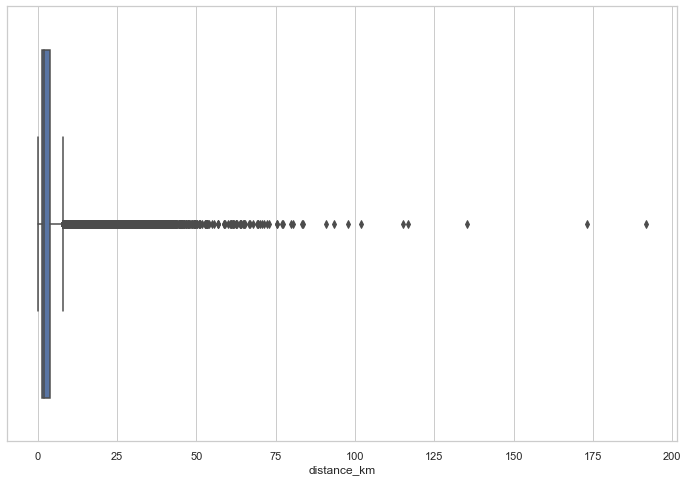

In [9]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_tempp, x='distance_km')           
plt.show() 

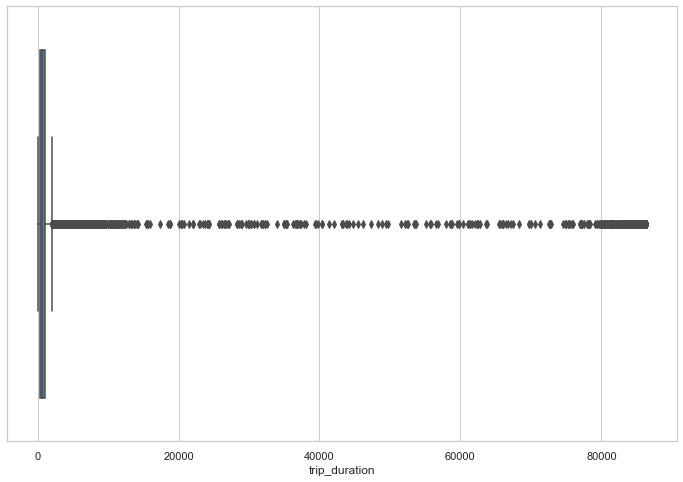

In [10]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_tempp, x='trip_duration')           
plt.show() 

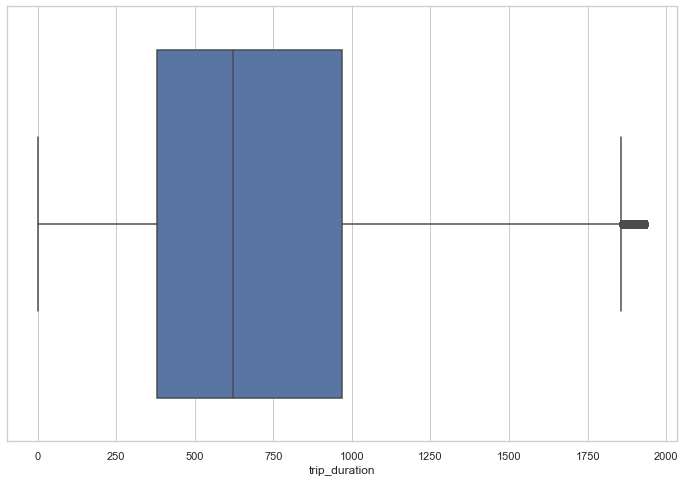

In [11]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='trip_duration')           
plt.show() 

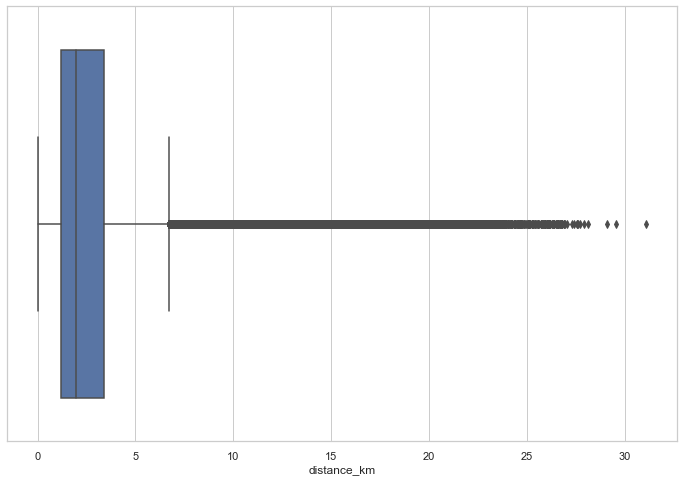

In [12]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='distance_km')           
plt.show() 

In [4]:
df_nyc = pd.read_csv('nyc_clean.csv')

In [6]:
df_nyc.head()

,trip_duration,distance_km,DayOfWeek,TimeOfDay
0,455.0,1.502172,Monday,Afternoon
1,663.0,1.808660,Sunday,Night
2,429.0,1.483632,Wednesday,Evening
3,435.0,1.187038,Saturday,Afternoon
4,443.0,1.099625,Saturday,Evening


In [13]:
# Calculate the IQR
Q1 = df_nyc['trip_duration'].quantile(0.25)
Q3 = df_nyc['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound_dur = Q1 - 1.5 * IQR
upper_bound_dur = Q3 + 1.5 * IQR

# Identify the outliers
outliers_duration = df_nyc[(df_nyc['trip_duration'] < lower_bound_dur) | (df_nyc['trip_duration'] > upper_bound_dur)]

# Count the number of outliers
num_outliers = len(outliers_duration)
print(upper_bound_dur)
print('Number of outliers:', num_outliers)
print ('Percentage of outliers:', (num_outliers/len(df_nyc))*100 ,'%')

1856.5
Number of outliers: 11351
Percentage of outliers: 0.8350861240041464 %


In [14]:
# Calculate the IQR
Q1 = df_tempp['trip_duration'].quantile(0.25)
Q3 = df_tempp['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound_dur = Q1 - 1.5 * IQR
upper_bound_dur = Q3 + 1.5 * IQR

# Identify the outliers
outliers_duration = df_nyc[(df_tempp['trip_duration'] < lower_bound_dur) | (df_tempp['trip_duration'] > upper_bound_dur)]

# Count the number of outliers
num_outliers = len(outliers_duration)
print(upper_bound_dur)
print('Number of outliers:', num_outliers)
print ('Percentage of outliers:', (num_outliers/len(df_tempp))*100 ,'%')

<ipython-input-14-966f56af489d>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_duration = df_nyc[(df_tempp['trip_duration'] < lower_bound_dur) | (df_tempp['trip_duration'] > upper_bound_dur)]


2092.5
Number of outliers: 69020
Percentage of outliers: 4.732174812104824 %


In [15]:
# Calculate the IQR
Q1 = df_nyc['distance_km'].quantile(0.25)
Q3 = df_nyc['distance_km'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound_dur = Q1 - 1.5 * IQR
upper_bound_dur = Q3 + 1.5 * IQR

# Identify the outliers
outliers_distance = df_nyc[(df_nyc['distance_km'] < lower_bound_dur) | (df_nyc['distance_km'] > upper_bound_dur)]

# Count the number of outliers
num_outliers = len(outliers_distance)
print(upper_bound_dur)
print('Number of outliers:', num_outliers)
print ('Percentage of outliers:', (num_outliers/len(df_nyc))*100 ,'%')

6.6969720756556015
Number of outliers: 101381
Percentage of outliers: 7.458538132117379 %


In [16]:
# Calculate the IQR
Q1 = df_tempp['distance_km'].quantile(0.25)
Q3 = df_tempp['distance_km'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound_dur = Q1 - 1.5 * IQR
upper_bound_dur = Q3 + 1.5 * IQR

# Identify the outliers
outliers_distance = df_tempp[(df_tempp['distance_km'] < lower_bound_dur) | (df_tempp['distance_km'] > upper_bound_dur)]

# Count the number of outliers
num_outliers = len(outliers_distance)
print(upper_bound_dur)
print('Number of outliers:', num_outliers)
print ('Percentage of outliers:', (num_outliers/len(df_tempp))*100 ,'%')

7.838074266859958
Number of outliers: 140749
Percentage of outliers: 9.650085085901793 %


In [239]:
df_tempp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458526 entries, 0 to 1458525
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458526 non-null  int64  
 1   passenger_count     1458526 non-null  int64  
 2   store_and_fwd_flag  1458526 non-null  object 
 3   trip_duration       1458526 non-null  float64
 4   pickup              1458526 non-null  object 
 5   dropoff             1458526 non-null  object 
 6   distance_km         1458526 non-null  float64
 7   min_duration        1458526 non-null  float64
 8   Month               1458526 non-null  int64  
 9   Day                 1458526 non-null  int64  
 10  Hour                1458526 non-null  int64  
 11  DayOfWeek           1458526 non-null  object 
 12  TimeOfDay           1458526 non-null  object 
 13  dropoff_is_in_nyc   1458526 non-null  bool   
 14  pickup_is_in_nyc    1458526 non-null  bool   
dtypes: bool(2), flo

In [24]:
df_nyc = df_tempp[(df_tempp['dropoff_is_in_nyc'] == True) & (df_tempp['pickup_is_in_nyc'] == True)]

In [24]:
df_nyc

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
0,2,1,N,7.583333,"(40.76793670654297, -73.98215484619139)","(40.765602111816406, -73.96463012695312)",1.502172,0.657885,3,14,17,Monday,Afternoon,True,True
1,1,1,N,11.050000,"(40.738563537597656, -73.98041534423827)","(40.731151580810554, -73.99948120117188)",1.808660,0.792114,6,12,0,Sunday,Night,True,True
2,2,1,N,35.400000,"(40.763938903808594, -73.97902679443358)","(40.710086822509766, -74.00533294677734)",6.379687,2.794024,1,19,11,Tuesday,Morning,True,True
3,2,1,N,7.150000,"(40.719970703125, -74.01004028320312)","(40.70671844482422, -74.01226806640625)",1.483632,0.649766,4,6,19,Wednesday,Evening,True,True
4,2,1,N,7.250000,"(40.79320907592773, -73.97305297851561)","(40.782520294189446, -73.9729232788086)",1.187038,0.519871,3,26,13,Saturday,Afternoon,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458521,2,4,N,12.966667,"(40.74552154541016, -73.9822006225586)","(40.74016952514648, -73.99491119384764)",1.227090,0.537412,4,8,13,Friday,Afternoon,True,True
1458522,1,1,N,10.916667,"(40.74737930297852, -74.00094604492188)","(40.79654693603516, -73.97018432617188)",6.046212,2.647976,1,10,7,Sunday,Morning,True,True
1458523,2,1,N,12.733333,"(40.768798828125, -73.9591293334961)","(40.70737075805664, -74.00443267822266)",7.821532,3.425488,4,22,6,Friday,Night,True,True
1458524,1,1,N,6.216667,"(40.749061584472656, -73.9820785522461)","(40.75710678100586, -73.97463226318358)",1.092524,0.478478,1,5,15,Tuesday,Afternoon,True,True


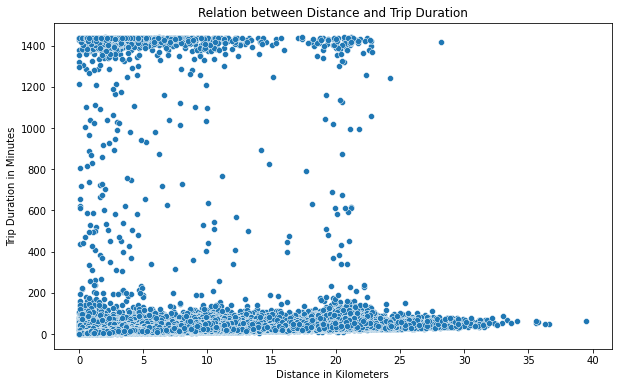

In [12]:
plt.figure(figsize=(10, 6))  
sns.scatterplot(x=df_nyc['distance_km'], y=df_nyc['trip_duration'])
plt.title('Relation between Distance and Trip Duration')
plt.xlabel('Distance in Kilometers')
plt.ylabel('Trip Duration in Minutes')
plt.show()

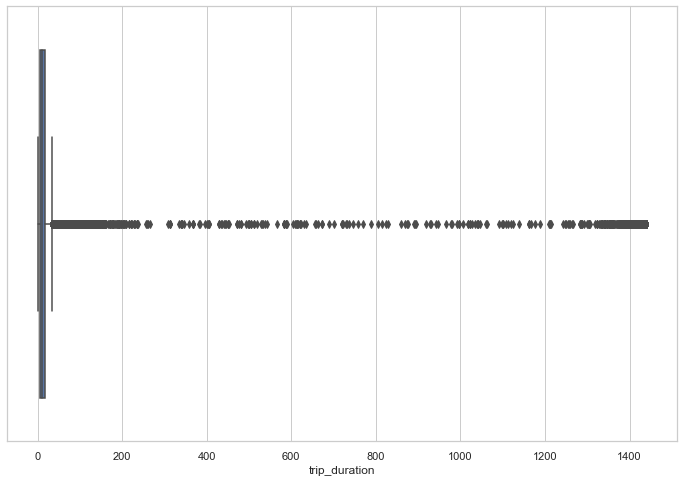

In [13]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='trip_duration')           
plt.show()

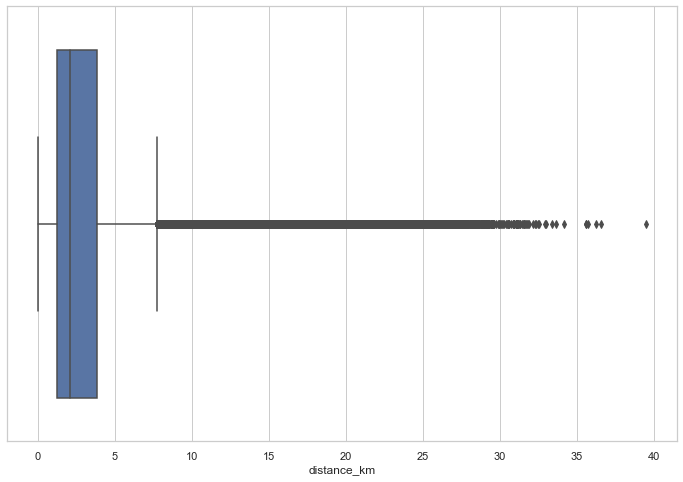

In [14]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='distance_km')           
plt.show() 

In [15]:
len(df_nyc[df_nyc['distance_km'] > 100])

0

In [25]:
df_nyc = df_nyc[df_nyc['distance_km'] < 100]

In [6]:
df_nyc[(df_nyc['distance_km'])/(df_nyc['trip_duration']/60) >= 200]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc


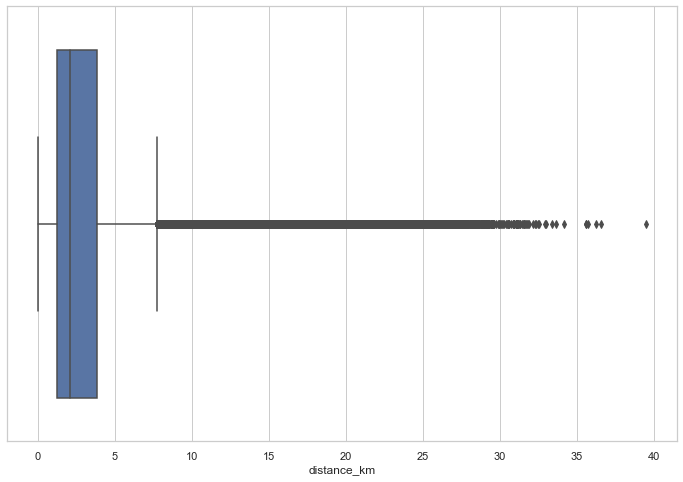

In [17]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='distance_km')           
plt.show() 

In [19]:
df_nyc[df_nyc['distance_km'] == 0]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
246,2,1,N,0.0,"(40.76896286010742, -73.98181915283203)","(40.76896286010742, -73.98181915283203)",0.0,0.0,2,29,18,Monday,Afternoon,True,True
291,2,2,N,0.0,"(40.77566146850586, -73.95906829833984)","(40.77566146850586, -73.95906829833984)",0.0,0.0,5,10,18,Tuesday,Afternoon,True,True
407,2,6,N,0.0,"(40.68733596801758, -73.80848693847656)","(40.68733596801758, -73.80848693847656)",0.0,0.0,5,16,23,Monday,Evening,True,True
702,1,1,N,0.0,"(40.64704132080078, -73.78672027587889)","(40.64704132080078, -73.78672027587889)",0.0,0.0,1,25,19,Monday,Evening,True,True
1727,1,1,N,0.0,"(40.64545440673828, -73.77631378173827)","(40.64545440673828, -73.77631378173827)",0.0,0.0,1,22,16,Friday,Afternoon,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456281,2,1,N,0.0,"(40.75672149658203, -73.9788589477539)","(40.75672149658203, -73.9788589477539)",0.0,0.0,2,17,8,Wednesday,Morning,True,True
1456509,2,1,N,0.0,"(40.768516540527344, -73.96355438232422)","(40.768516540527344, -73.96355438232422)",0.0,0.0,2,6,22,Saturday,Evening,True,True
1456871,2,1,N,0.0,"(40.728221893310554, -73.98484802246092)","(40.728221893310554, -73.98484802246092)",0.0,0.0,3,12,7,Saturday,Morning,True,True
1456996,2,1,N,0.0,"(40.77098846435546, -73.96598052978516)","(40.77098846435546, -73.96598052978516)",0.0,0.0,4,9,20,Saturday,Evening,True,True


In [21]:
pd.options.display.float_format = '{:.4f}'.format

In [171]:
df_nyc['distance_km'].describe()

count   1448444.0000
mean          3.3881
std           3.8141
min           0.0000
25%           1.2308
50%           2.0871
75%           3.8449
max          39.5091
Name: distance_km, dtype: float64

In [23]:
df_nyc[df_nyc['distance_km'] > 3.8763]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
2,2,1,N,35.4000,"(40.763938903808594, -73.97902679443358)","(40.710086822509766, -74.00533294677734)",6.3797,2.7940,1,19,11,Tuesday,Morning,True,True
7,2,1,N,25.8500,"(40.79777908325195, -73.96927642822266)","(40.76055908203125, -73.92247009277344)",5.7180,2.5042,5,21,7,Saturday,Morning,True,True
9,2,1,N,20.4167,"(40.744338989257805, -73.98104858398438)","(40.78998947143555, -73.9729995727539)",5.1148,2.2401,3,10,21,Thursday,Evening,True,True
14,2,1,N,23.5667,"(40.72722625732422, -73.99219512939453)","(40.783069610595696, -73.9746551513672)",6.3758,2.7923,5,27,0,Friday,Night,True,True
18,1,1,N,21.9500,"(40.7130126953125, -74.00398254394531)","(40.74992370605469, -73.97919464111328)",4.6028,2.0158,6,27,9,Monday,Morning,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458502,2,1,N,19.3667,"(40.75807189941406, -73.96632385253906)","(40.736640930175774, -74.0065155029297)",4.1456,1.8156,4,28,20,Thursday,Evening,True,True
1458514,2,2,N,12.9500,"(40.710891723632805, -74.01557159423827)","(40.74363327026367, -73.99662017822266)",3.9728,1.7399,3,6,11,Sunday,Morning,True,True
1458516,1,2,N,16.2000,"(40.730464935302734, -73.98907470703125)","(40.773738861083984, -73.96388244628906)",5.2554,2.3016,4,3,13,Sunday,Afternoon,True,True
1458522,1,1,N,10.9167,"(40.74737930297852, -74.00094604492188)","(40.79654693603516, -73.97018432617188)",6.0462,2.6480,1,10,7,Sunday,Morning,True,True


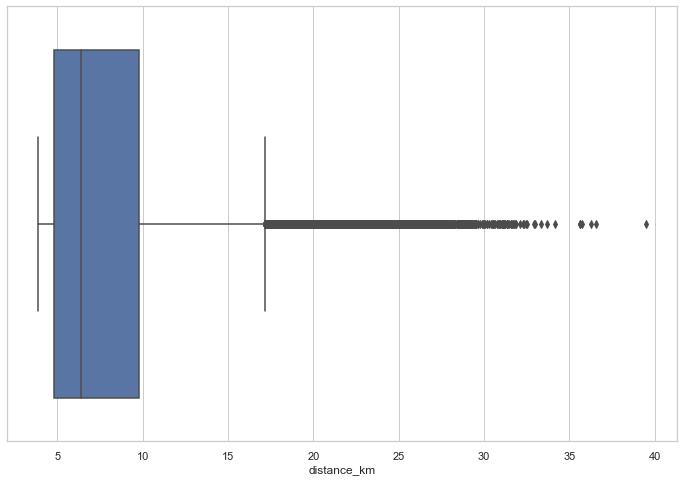

In [24]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc[df_nyc['distance_km'] > 3.8449] , x='distance_km')           
plt.show() 

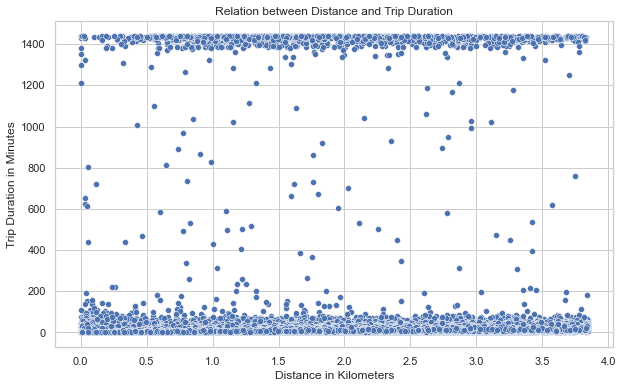

In [25]:
plt.figure(figsize=(10, 6))  
sns.scatterplot(x=df_nyc[df_nyc['distance_km'] <= 3.8449]['distance_km'], y=df_nyc['trip_duration'])
plt.title('Relation between Distance and Trip Duration')
plt.xlabel('Distance in Kilometers')
plt.ylabel('Trip Duration in Minutes')
plt.show()

In [51]:
df_nyc[df_nyc['distance_km'] <= 3.8763]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay,dropoff_is_in_nyc,pickup_is_in_nyc
id,,,,,,,,,,,,,,,
id2875421,2,1,N,7.5833,"(40.76793670654297, -73.98215484619139)","(40.765602111816406, -73.96463012695312)",1.5022,0.6579,3,14,17,Monday,Afternoon,True,True
id2377394,1,1,N,11.0500,"(40.738563537597656, -73.98041534423827)","(40.731151580810554, -73.99948120117188)",1.8087,0.7921,6,12,0,Sunday,Night,True,True
id3504673,2,1,N,7.1500,"(40.719970703125, -74.01004028320312)","(40.70671844482422, -74.01226806640625)",1.4836,0.6498,4,6,19,Wednesday,Evening,True,True
id2181028,2,1,N,7.2500,"(40.79320907592773, -73.97305297851561)","(40.782520294189446, -73.9729232788086)",1.1870,0.5199,3,26,13,Saturday,Afternoon,True,True
id0801584,2,6,N,7.3833,"(40.74219512939453, -73.98285675048828)","(40.74918365478516, -73.99208068847656)",1.0996,0.4816,1,30,22,Saturday,Evening,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id1920898,1,1,N,12.6667,"(40.75170516967773, -73.97535705566406)","(40.776763916015625, -73.94947814941406)",3.5381,1.5495,4,17,18,Sunday,Afternoon,True,True
id1454193,2,5,N,6.9000,"(40.73655319213867, -73.98882293701173)","(40.75739288330078, -73.98916625976561)",2.3144,1.0136,2,2,0,Tuesday,Night,True,True
id2376096,2,4,N,12.9667,"(40.74552154541016, -73.9822006225586)","(40.74016952514648, -73.99491119384764)",1.2271,0.5374,4,8,13,Friday,Afternoon,True,True


In [172]:
df_nyc['trip_duration'].describe()

count   1448444.0000
mean         15.7644
std          52.7533
min           0.0000
25%           6.5833
50%          10.9833
75%          17.8167
max        1439.8667
Name: trip_duration, dtype: float64

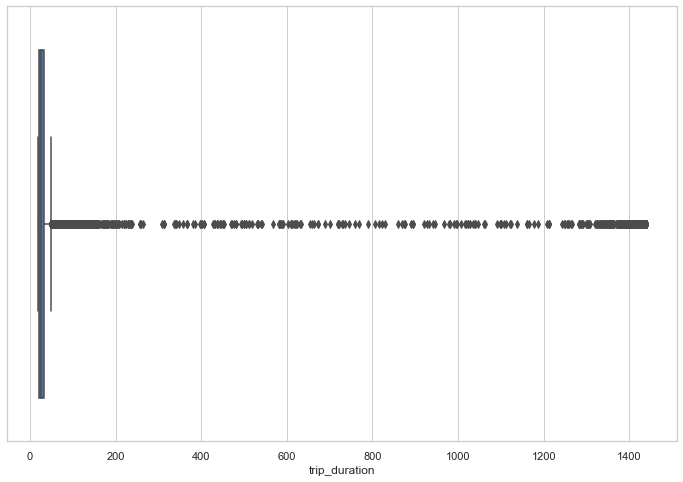

In [27]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc[df_nyc['trip_duration'] > 17.9] , x='trip_duration')           
plt.show()

In [26]:
df_nyc.drop(columns=['pickup','dropoff','dropoff_is_in_nyc','pickup_is_in_nyc'], inplace=True)

In [27]:
df_nyc.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay
0,2,1,N,7.583333,1.502172,0.657885,3,14,17,Monday,Afternoon
1,1,1,N,11.050000,1.808660,0.792114,6,12,0,Sunday,Night
2,2,1,N,35.400000,6.379687,2.794024,1,19,11,Tuesday,Morning
3,2,1,N,7.150000,1.483632,0.649766,4,6,19,Wednesday,Evening
4,2,1,N,7.250000,1.187038,0.519871,3,26,13,Saturday,Afternoon


In [83]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457537 entries, id2875421 to id1209952
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   vendor_id           1457537 non-null  category
 1   passenger_count     1457537 non-null  category
 2   store_and_fwd_flag  1457537 non-null  category
 3   trip_duration       1457537 non-null  float64 
 4   distance_km         1457537 non-null  float64 
 5   min_duration        1457537 non-null  float64 
 6   Month               1457537 non-null  category
 7   Day                 1457537 non-null  category
 8   Hour                1457537 non-null  category
 9   DayOfWeek           1457537 non-null  category
 10  TimeOfDay           1457537 non-null  category
dtypes: category(8), float64(3)
memory usage: 87.9+ MB


In [28]:
# Calculate the IQR
Q1 = df_nyc['trip_duration'].quantile(0.25)
Q3 = df_nyc['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound_dur = Q1 - 1.5 * IQR
upper_bound_dur = Q3 + 1.5 * IQR

# Identify the outliers
outliers_duration = df_nyc[(df_nyc['trip_duration'] < lower_bound_dur) | (df_nyc['trip_duration'] > upper_bound_dur)]

# Count the number of outliers
num_outliers = len(outliers_duration)
print(upper_bound_dur)
print('Number of outliers:', num_outliers)
print ('Percentage of outliers:', (num_outliers/len(df_nyc))*100 ,'%')

34.66666666666667
Number of outliers: 72675
Percentage of outliers: 5.017453211860452 %


In [29]:
# Calculate the IQR
Q1 = df_nyc['distance_km'].quantile(0.25)
Q3 = df_nyc['distance_km'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound_dis = Q1 - 1.5 * IQR
upper_bound_dis = Q3 + 1.5 * IQR

# Identify the outliers
outliers_distance = df_nyc[(df_nyc['distance_km'] < lower_bound_dis) | (df_nyc['distance_km'] > upper_bound_dis)]

# Count the number of outliers
num_outliers = len(outliers_distance)
print(upper_bound_dis)
print('Number of outliers:', num_outliers)
print ('Percentage of outliers:', (num_outliers/len(df_nyc))*100 ,'%')

7.766108215152906
Number of outliers: 137852
Percentage of outliers: 9.517247473840893 %


In [33]:
len(df_nyc[((df_nyc['distance_km'] < lower_bound_dis) | (df_nyc['distance_km'] > upper_bound_dis)) & 
       ((df_nyc['trip_duration'] < lower_bound_dur) | (df_nyc['trip_duration'] > upper_bound_dur))]) / len(df_nyc)

0.037762592133351376

In [34]:
len(df_nyc[((df_nyc['distance_km'] < lower_bound_dis) | (df_nyc['distance_km'] > upper_bound_dis)) & 
       ((df_nyc['trip_duration'] < lower_bound_dur) | (df_nyc['trip_duration'] > upper_bound_dur))])

54697

In [30]:
df_nyc.drop(
    df_nyc[
       ((df_nyc['distance_km'] < lower_bound_dis) | (df_nyc['distance_km'] > upper_bound_dis)) 
        & 
       ((df_nyc['trip_duration'] < lower_bound_dur) | (df_nyc['trip_duration'] > upper_bound_dur))
      ].index, inplace = True
)

In [178]:
df_nyc.shape

(1393747, 11)

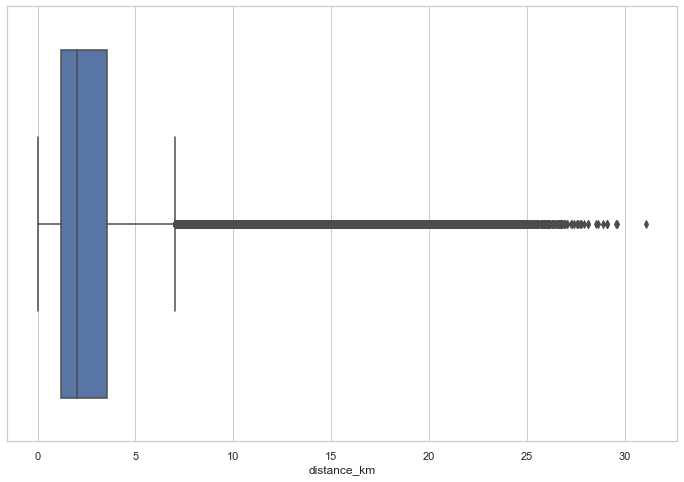

In [37]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='distance_km')           
plt.show() 

In [31]:
df_nyc['trip_duration'] = df_nyc['trip_duration']/60
df_nyc['min_duration'] = df_nyc['min_duration']/60

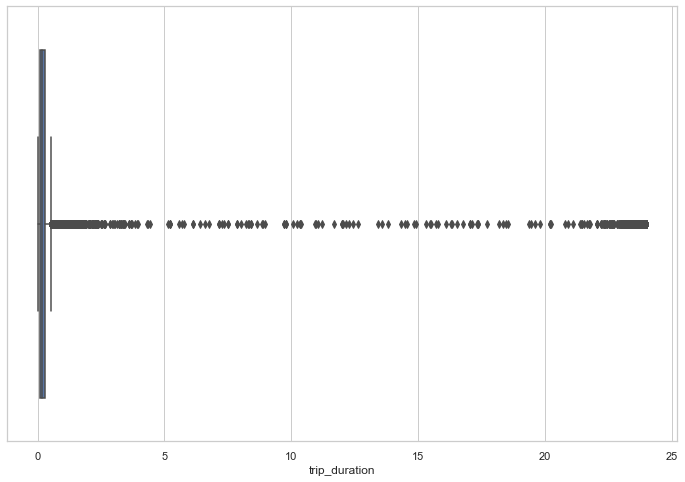

In [40]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='trip_duration')           
plt.show() 

In [32]:
# Calculate the IQR
Q1 = df_nyc['trip_duration'].quantile(0.25)
Q3 = df_nyc['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound_dur = Q1 - 1.5 * IQR
upper_bound_dur = Q3 + 1.5 * IQR

# Identify the outliers
outliers_duration = df_nyc[(df_nyc['trip_duration'] < lower_bound_dur) | (df_nyc['trip_duration'] > upper_bound_dur)]

# Count the number of outliers
num_outliers = len(outliers_duration)
print(upper_bound_dur)
print('Number of outliers:', num_outliers)
print ('Percentage of outliers:', (num_outliers/len(df_nyc))*100 ,'%')

0.5381944444444444
Number of outliers: 34486
Percentage of outliers: 2.4743371644925514 %


In [33]:
df_nyc = df_nyc[df_nyc['trip_duration'] <= upper_bound_dur]

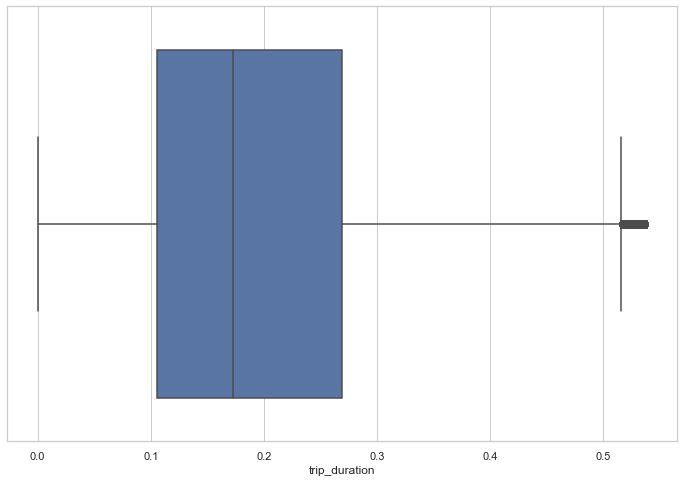

In [43]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='trip_duration')           
plt.show() 

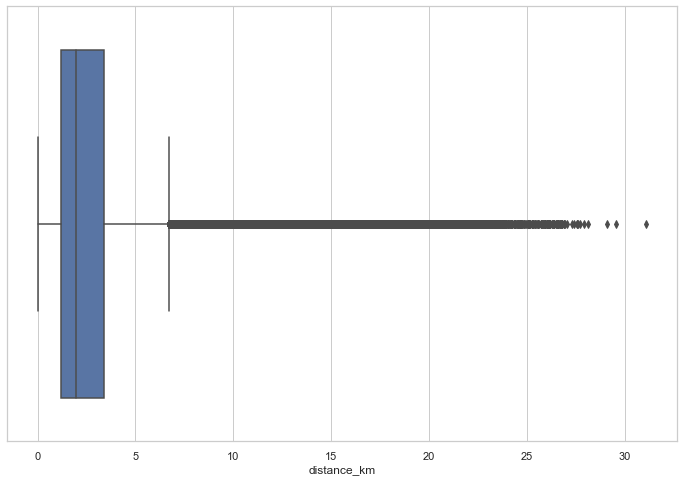

In [44]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='distance_km')           
plt.show() 

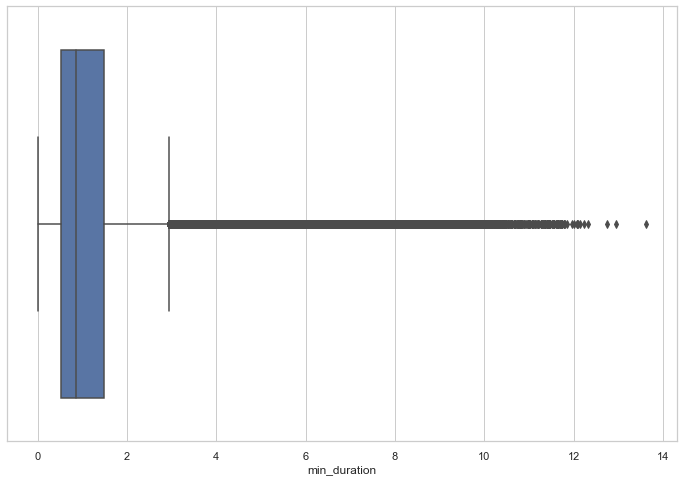

In [64]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  
sns.boxplot(data=df_nyc, x='min_duration')           
plt.show() 

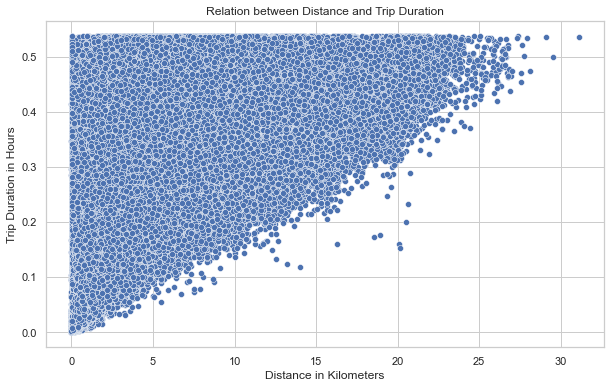

In [45]:
plt.figure(figsize=(10, 6))  
sns.scatterplot(x=df_nyc['distance_km'], y=df_nyc['trip_duration'])
plt.title('Relation between Distance and Trip Duration')
plt.xlabel('Distance in Kilometers')
plt.ylabel('Trip Duration in Hours')
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
minmax_scaler = MinMaxScaler()

In [16]:
df_nyc['distance_km'] = minmax_scaler.fit_transform(df_nyc[['distance_km']])

In [17]:
df_nyc.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km,min_duration,Month,Day,Hour,DayOfWeek,TimeOfDay
0,2,1,N,0.126389,0.048279,0.010965,3,14,17,Monday,Afternoon
1,1,1,N,0.184167,0.058129,0.013202,6,12,0,Sunday,Night
3,2,1,N,0.119167,0.047683,0.010829,4,6,19,Wednesday,Evening
4,2,1,N,0.120833,0.038151,0.008665,3,26,13,Saturday,Afternoon
5,2,6,N,0.123056,0.035341,0.008026,1,30,22,Saturday,Evening


In [15]:
min_dis = df_nyc['distance_km'].min()
max_dis = df_nyc['distance_km'].max()
df_nyc['distance_km'] = (df_nyc['distance_km'] - min_dis) / (max_dis - min_dis)

In [16]:
min_dur = df_nyc['min_duration'].min()
max_dur = df_nyc['min_duration'].max()
df_nyc['min_duration'] = (df_nyc['min_duration'] - min_dur) / (max_dur - min_dur)

In [48]:
df_nyc['distance_km'].max()

1.0

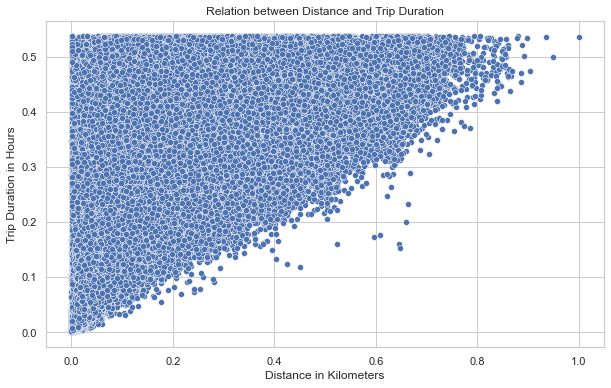

In [184]:
plt.figure(figsize=(10, 6))  
sns.scatterplot(x=df_nyc['distance_km'], y=df_nyc['trip_duration'])
plt.title('Relation between Distance and Trip Duration')
plt.xlabel('Distance in Kilometers')
plt.ylabel('Trip Duration in Hours')
plt.show()

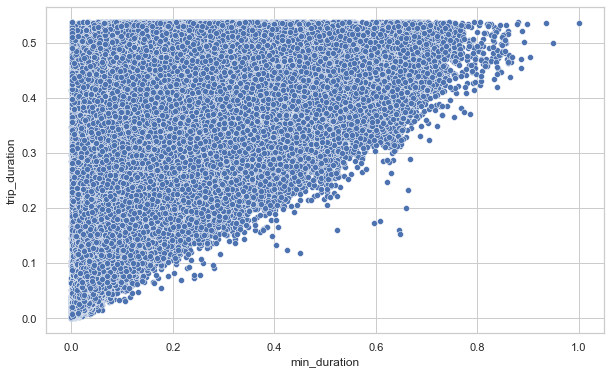

In [185]:
plt.figure(figsize=(10, 6))  
sns.scatterplot(x=df_nyc['min_duration'], y=df_nyc['trip_duration'])
plt.show()

In [34]:
df_nyc.drop(columns=['min_duration'], inplace = True)

In [35]:
df_nyc['trip_duration'] = df_nyc['trip_duration']*3600

In [36]:
df_nyc.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km,Month,Day,Hour,DayOfWeek,TimeOfDay
0,2,1,N,455.0,1.502172,3,14,17,Monday,Afternoon
1,1,1,N,663.0,1.808660,6,12,0,Sunday,Night
3,2,1,N,429.0,1.483632,4,6,19,Wednesday,Evening
4,2,1,N,435.0,1.187038,3,26,13,Saturday,Afternoon
5,2,6,N,443.0,1.099625,1,30,22,Saturday,Evening


In [236]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359261 entries, 0 to 1458525
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1359261 non-null  int64  
 1   passenger_count     1359261 non-null  int64  
 2   store_and_fwd_flag  1359261 non-null  object 
 3   trip_duration       1359261 non-null  float64
 4   distance_km         1359261 non-null  float64
 5   Month               1359261 non-null  int64  
 6   Day                 1359261 non-null  int64  
 7   Hour                1359261 non-null  int64  
 8   DayOfWeek           1359261 non-null  object 
 9   TimeOfDay           1359261 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 114.1+ MB


In [237]:
df_tempp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458526 entries, 0 to 1458525
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458526 non-null  int64  
 1   passenger_count     1458526 non-null  int64  
 2   store_and_fwd_flag  1458526 non-null  object 
 3   trip_duration       1458526 non-null  float64
 4   pickup              1458526 non-null  object 
 5   dropoff             1458526 non-null  object 
 6   distance_km         1458526 non-null  float64
 7   min_duration        1458526 non-null  float64
 8   Month               1458526 non-null  int64  
 9   Day                 1458526 non-null  int64  
 10  Hour                1458526 non-null  int64  
 11  DayOfWeek           1458526 non-null  object 
 12  TimeOfDay           1458526 non-null  object 
 13  dropoff_is_in_nyc   1458526 non-null  bool   
 14  pickup_is_in_nyc    1458526 non-null  bool   
dtypes: bool(2), flo

In [19]:
df_nyc.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km,Month,Day,Hour,DayOfWeek,TimeOfDay
0,2,1,N,455.0,0.048279,3,14,17,Monday,Afternoon
1,1,1,N,663.0,0.058129,6,12,0,Sunday,Night
3,2,1,N,429.0,0.047683,4,6,19,Wednesday,Evening
4,2,1,N,435.0,0.038151,3,26,13,Saturday,Afternoon
5,2,6,N,443.0,0.035341,1,30,22,Saturday,Evening


# Modeling

In [9]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler

In [36]:
df_nyc['DayOfWeek'] = df_nyc['DayOfWeek'].astype('category')
df_nyc['Hour'] = df_nyc['Hour'].astype('category')
df_nyc['TimeOfDay'] = df_nyc['TimeOfDay'].astype('category')

In [43]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359261 entries, 0 to 1458525
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   trip_duration  1359261 non-null  float64
 1   distance_km    1359261 non-null  float64
 2   DayOfWeek      1359261 non-null  object 
 3   TimeOfDay      1359261 non-null  object 
dtypes: float64(2), object(2)
memory usage: 51.9+ MB


In [45]:
target = 'trip_duration'
X = df_nyc.drop(columns = target)
y = df_nyc[target]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [48]:
y_train.describe()

count    869926.000000
mean        711.639722
std         425.761222
min           0.000000
25%         379.000000
50%         622.000000
75%         969.000000
max        1937.000000
Name: trip_duration, dtype: float64

### Baseline Model

In [207]:
y_train.mean()

711.6397222292471

In [208]:
y_train.median()

622.0

In [209]:
baseline_train = [y_train.median()] * len(y_train)
baseline_val = [y_train.median()] * len(y_val)

In [210]:
(y_train - baseline_train)

127264    -369.0000
1005196   -198.0000
1019630   -353.0000
606491    -334.0000
1092077     -1.0000
             ...   
102842     871.0000
18694      228.0000
1229161   -123.0000
1228920    -46.0000
1096267   -207.0000
Name: trip_duration, Length: 869926, dtype: float64

In [211]:
r2_train = r2_score(y_train,baseline_train)
r2_val = r2_score(y_val,baseline_val)
rmsle_train = np.sqrt(mean_squared_log_error(y_train, baseline_train))
rmsle_val = np.sqrt(mean_squared_log_error(y_val, baseline_val))

In [212]:
print("Baseline Model Evaluation")
print('----------------------------')
print("Training Accuracy:", round(r2_train, 4))
print("Validation Accuracy:", round(r2_val, 4))
print("Training Error:", round(rmsle_train, 4))
print("Validation Error:", round(rmsle_val, 4))

Baseline Model Evaluation
----------------------------
Training Accuracy: -0.0443
Validation Accuracy: -0.0458
Training Error: 0.801
Validation Error: 0.8028


### Decision Tree Regressor

In [213]:
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeRegressor(random_state = 42, max_depth = 10))

In [214]:
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['store_and_fwd_flag', 'DayOfWeek',
                                      'TimeOfDay'],
                                mapping=[{'col': 'store_and_fwd_flag',
                                          'data_type': dtype('O'),
                                          'mapping': N      1
Y      2
NaN   -2
dtype: int64},
                                         {'col': 'DayOfWeek',
                                          'data_type': dtype('O'),
                                          'mapping': Tuesday      1
Sunday       2
Wednesday    3
Saturday     4
Friday       5
Thursday     6
Monday       7
NaN         -2
dtype: int64},
                                         {'col': 'TimeOfDay',
                                          'data_type': dtype('O'),
                                          'mapping': Evening      1
Night        2
Afternoon    3
Morning      4
NaN         -2
dtype: int64}])),
               

In [215]:
r2_train = r2_score(y_train, model.predict(X_train))
r2_val = r2_score(y_val, model.predict(X_val))
rmsle_train = np.sqrt(mean_squared_log_error(y_train, model.predict(X_train)))
rmsle_val = np.sqrt(mean_squared_log_error(y_val,  model.predict(X_val)))

In [216]:
print("Decision Tree Model Evaluation")
print('------------------------------')
print("Training Accuracy:", round(r2_train, 4))
print("Validation Accuracy:", round(r2_val, 4))
print("Training Error:", round(rmsle_train, 4))
print("Validation Error:", round(rmsle_val, 4))

Decision Tree Model Evaluation
------------------------------
Training Accuracy: 0.6504
Validation Accuracy: 0.6472
Training Error: 0.4244
Validation Error: 0.4282


In [217]:
np.sqrt(mean_squared_log_error(y_test,  model.predict(X_test)))

0.4277303812633345

In [218]:
r2_score(y_test, model.predict(X_test))

0.6474124387569634

In [109]:
model.named_steps["decisiontreeregressor"].get_depth()

15

In [83]:
depth_hyperparams = range(6,30,2)

In [222]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []
training_rmsle = []
validation_rmsle = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeRegressor(random_state=42,max_depth=d)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    training_rmsle.append(mean_squared_log_error(y_train,  test_model.predict(X_train)))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val,y_val))
    validation_rmsle.append(mean_squared_log_error(y_val,  test_model.predict(X_val)))


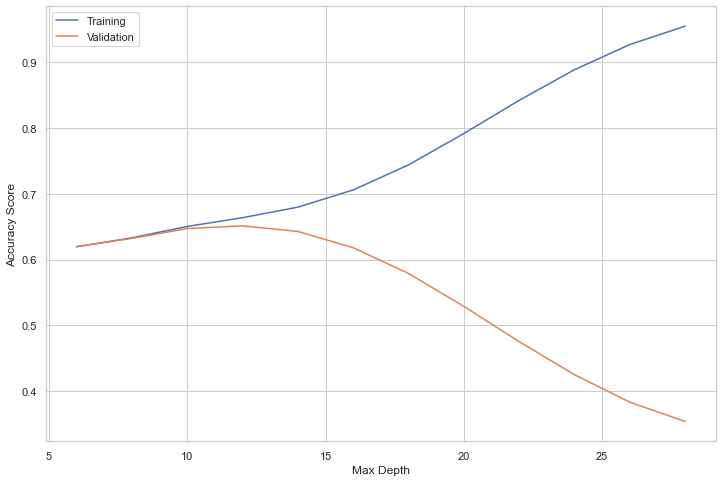

In [223]:
plt.figure(figsize=(12,8))
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

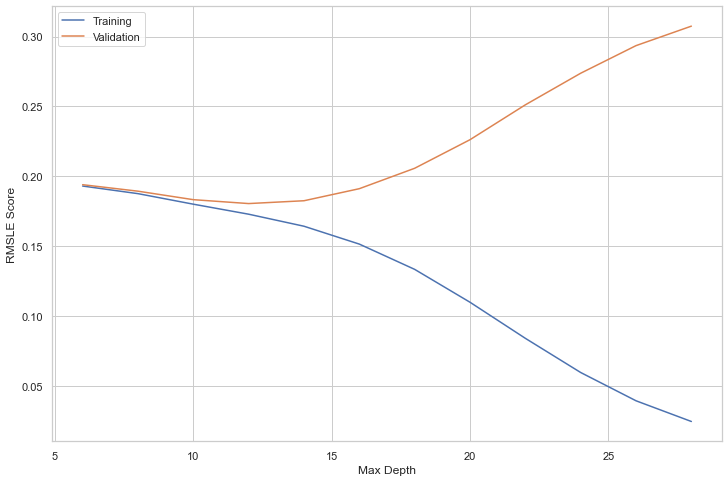

In [224]:
plt.figure(figsize=(12,8))
plt.plot(depth_hyperparams, training_rmsle, label="Training")
plt.plot(depth_hyperparams, validation_rmsle, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("RMSLE Score")
plt.legend();

In [86]:
model.named_steps["decisiontreeregressor"].feature_importances_

array([4.59404513e-05, 1.40341160e-04, 2.31342655e-05, 1.10811163e-01,
       7.49933263e-01, 2.28940769e-03, 6.16539726e-04, 4.18765983e-02,
       4.28356052e-02, 5.14280071e-02])

In [118]:
features = X_train.columns
importances = model.named_steps["decisiontreeregressor"].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()

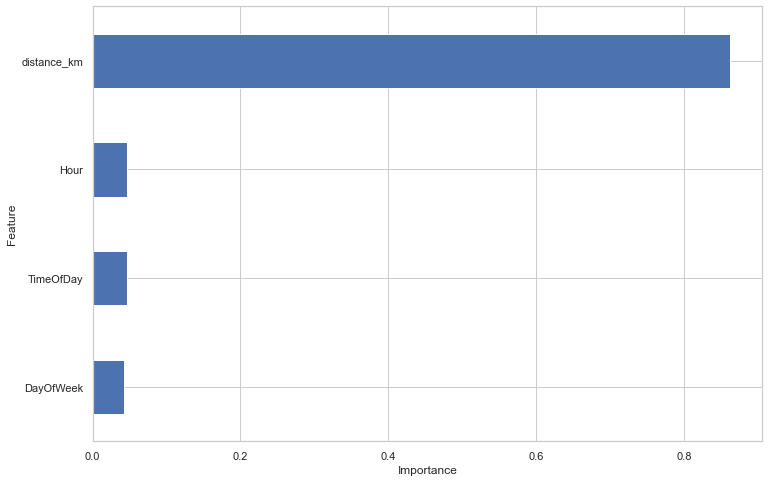

In [119]:
plt.figure(figsize=(12,8))
feat_imp.plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature");

In [37]:
df_nyc.drop(columns = ['Month', 'Day', 'passenger_count', 'vendor_id', 'store_and_fwd_flag', 'Hour'], inplace = True)

In [38]:
df_nyc.head()

,trip_duration,distance_km,DayOfWeek,TimeOfDay
0,455.0,1.502172,Monday,Afternoon
1,663.0,1.808660,Sunday,Night
3,429.0,1.483632,Wednesday,Evening
4,435.0,1.187038,Saturday,Afternoon
5,443.0,1.099625,Saturday,Evening


In [39]:
df_nyc.to_csv('nyc_clean.csv', index=False)

In [243]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359261 entries, 0 to 1458525
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   trip_duration  1359261 non-null  float64
 1   distance_km    1359261 non-null  float64
 2   Hour           1359261 non-null  int64  
 3   DayOfWeek      1359261 non-null  object 
 4   TimeOfDay      1359261 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 62.2+ MB


In [106]:
df_nyc['distance_km'].corr(df_nyc['min_duration'])

1.0

In [107]:
df_nyc['trip_duration'].corr(df_nyc['min_duration'])

0.6918340751747557

In [108]:
df_nyc['trip_duration'].corr(df_nyc['distance_km'])

0.6918340751747557

In [91]:
target = 'trip_duration'
X = df_nyc.drop(columns = target)
y = df_nyc[target]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [225]:
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeRegressor(random_state = 42, max_depth = 12))

In [226]:
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['store_and_fwd_flag', 'DayOfWeek',
                                      'TimeOfDay'],
                                mapping=[{'col': 'store_and_fwd_flag',
                                          'data_type': dtype('O'),
                                          'mapping': N      1
Y      2
NaN   -2
dtype: int64},
                                         {'col': 'DayOfWeek',
                                          'data_type': dtype('O'),
                                          'mapping': Tuesday      1
Sunday       2
Wednesday    3
Saturday     4
Friday       5
Thursday     6
Monday       7
NaN         -2
dtype: int64},
                                         {'col': 'TimeOfDay',
                                          'data_type': dtype('O'),
                                          'mapping': Evening      1
Night        2
Afternoon    3
Morning      4
NaN         -2
dtype: int64}])),
               

In [229]:
r2_train = r2_score(y_train, model.predict(X_train))
r2_val = r2_score(y_val, model.predict(X_val))
rmsle_train = np.sqrt(mean_squared_log_error(y_train, model.predict(X_train)))
rmsle_val = np.sqrt(mean_squared_log_error(y_val,  model.predict(X_val)))

In [230]:
print("Decision Tree Model Evaluation")
print('------------------------------')
print("Training Accuracy:", round(r2_train, 4))
print("Validation Accuracy:", round(r2_val, 4))
print("Training Error:", round(rmsle_train, 4))
print("Validation Error:", round(rmsle_val, 4))

Decision Tree Model Evaluation
------------------------------
Training Accuracy: 0.6637
Validation Accuracy: 0.6512
Training Error: 0.4159
Validation Error: 0.4249


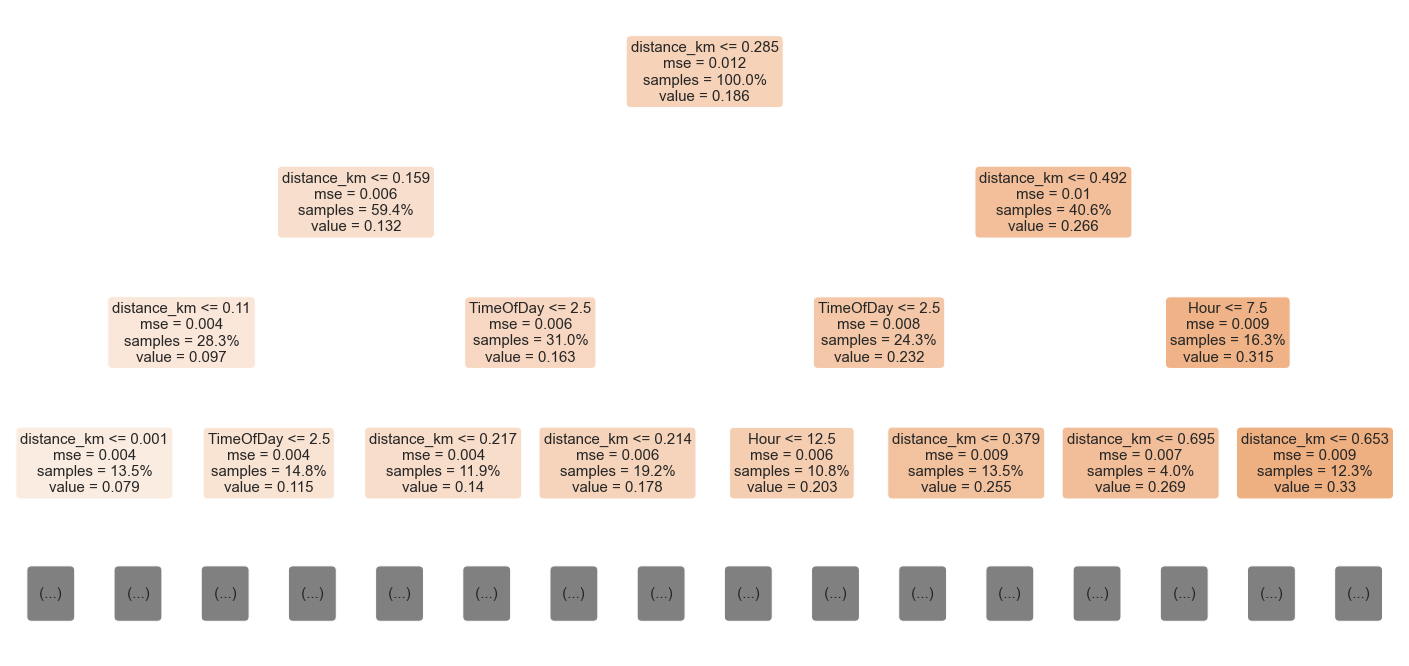

In [158]:
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeregressor"],
    feature_names=X_train.columns,
    filled=True,  
    rounded=True,  
    proportion=True,  
    fontsize=15,
    impurity=True,
    max_depth=3,
    ax=ax,  
);

In [45]:
DTR = make_pipeline(
    OneHotEncoder(),
    DecisionTreeRegressor(random_state = 42, max_depth = 10))

In [46]:
DTR.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['DayOfWeek', 'TimeOfDay'])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=10, random_state=42))])

In [47]:
r2_train = r2_score(y_train, DTR.predict(X_train))
r2_val = r2_score(y_val, DTR.predict(X_val))
rmsle_train = np.sqrt(mean_squared_log_error(y_train, DTR.predict(X_train)))
rmsle_val = np.sqrt(mean_squared_log_error(y_val,  DTR.predict(X_val)))

In [48]:
print("Decision Tree Model Evaluation")
print('------------------------------')
print("Training Accuracy:", round(r2_train, 4))
print("Validation Accuracy:", round(r2_val, 4))
print("Training Error:", round(rmsle_train, 4))
print("Validation Error:", round(rmsle_val, 4))

Decision Tree Model Evaluation
------------------------------
Training Accuracy: 0.653
Validation Accuracy: 0.65
Training Error: 0.4221
Validation Error: 0.4253


In [50]:
features = X_train.columns
importances = DTR.named_steps["decisiontreeregressor"].feature_importances_
#feat_imp = pd.Series(importances, index=features).sort_values()

In [51]:
importances

array([8.87360008e-01, 6.71819004e-02, 5.84899544e-04, 1.52036408e-02,
       3.11987478e-04, 1.13392010e-02, 8.62968288e-04, 3.35457808e-04,
       4.87668624e-03, 6.07688640e-03, 1.86313317e-03, 3.25489943e-03,
       7.48331854e-04])

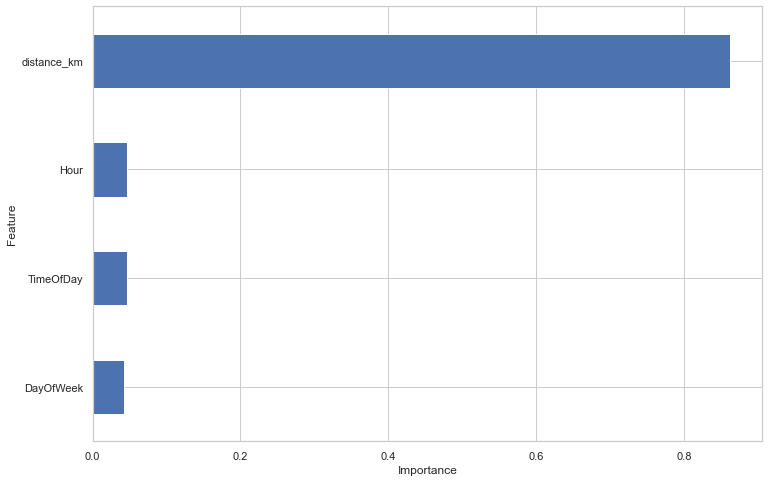

In [119]:
plt.figure(figsize=(12,8))
feat_imp.plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature");

### XGBoost

In [232]:
!pip install xgboost

In [53]:
from xgboost import XGBRegressor

In [235]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 869926 entries, 127264 to 1096267
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vendor_id           869926 non-null  int64  
 1   passenger_count     869926 non-null  int64  
 2   store_and_fwd_flag  869926 non-null  object 
 3   distance_km         869926 non-null  float64
 4   Month               869926 non-null  int64  
 5   Day                 869926 non-null  int64  
 6   Hour                869926 non-null  int64  
 7   DayOfWeek           869926 non-null  object 
 8   TimeOfDay           869926 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 66.4+ MB


In [252]:
xgb = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor(objective ='reg:squarederror', n_estimators= 100, max_depth=12, learning_rate=0.1, subsample=0.8))
xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Hour', 'DayOfWeek', 'TimeOfDay'],
                                mapping=[{'col': 'Hour',
                                          'data_type': CategoricalDtype(categories=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                  15, 16, 17, 18, 19, 20, 21, 22, 23],
, ordered=False),
                                          'mapping': 21.0000     1
19.0000     2
1.0000      3
0.0000      4
13.0000     5
18.0000     6
15.0000     7
8.0000      8
22.0000     9
14.0000    10
12.0000    11
23.0000    12
16.0000    13
7.000...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
       

In [255]:
r2_train = r2_score(y_train, xgb.predict(X_train))
r2_val = r2_score(y_val, xgb.predict(X_val))

In [256]:
print("XGBoost Model Evaluation")
print('---------------------------')
print("Training Accuracy:", round(r2_train, 4))
print("Validation Accuracy:", round(r2_val, 4))

XGBoost Model Evaluation
---------------------------
Training Accuracy: 0.6834
Validation Accuracy: 0.6544


In [257]:
depth_hyperparams = range(4,30,2)

In [259]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor(objective ='reg:squarederror', n_estimators= 100, max_depth=d, learning_rate=0.1, subsample=0.8))
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val,y_val))


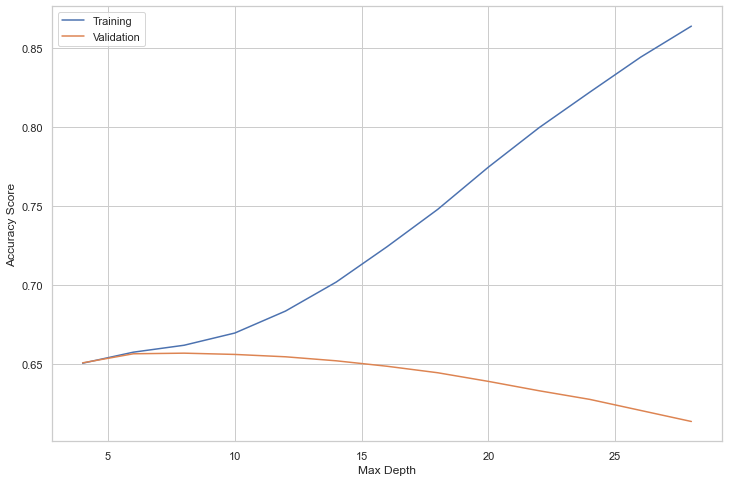

In [260]:
plt.figure(figsize=(12,8))
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [263]:
lr_hyperparams = np.arange(0.1, 0.9, 0.1)

In [265]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []


for lr in lr_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor(objective ='reg:squarederror', n_estimators= 100, max_depth=6, learning_rate=lr, subsample=0.8))
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val,y_val))

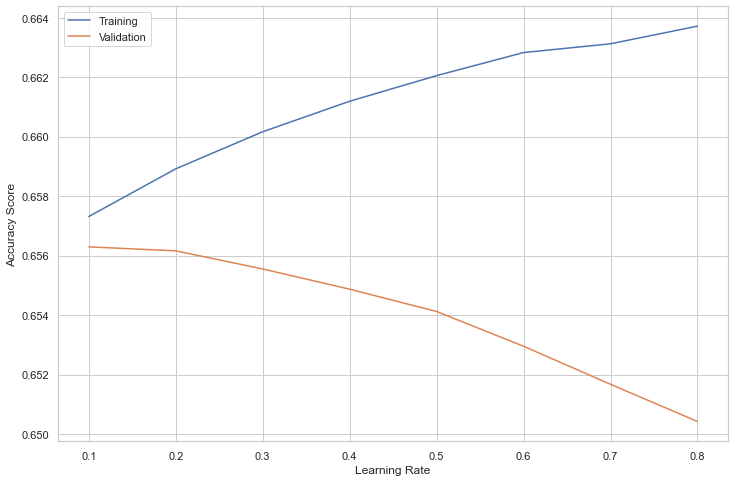

In [266]:
plt.figure(figsize=(12,8))
plt.plot(lr_hyperparams, training_acc, label="Training")
plt.plot(lr_hyperparams, validation_acc, label="Validation")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy Score")
plt.legend();

In [72]:
xgb = make_pipeline(
    OneHotEncoder(),
    XGBRegressor(objective ='reg:squarederror', n_estimators= 100, max_depth=6, learning_rate=0.2, subsample=0.8, random_state=42))
xgb.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['DayOfWeek', 'TimeOfDay'])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estima

In [73]:
r2_train = r2_score(y_train, xgb.predict(X_train))
r2_val = r2_score(y_val, xgb.predict(X_val))

In [74]:
print("XGBoost Model Evaluation")
print('---------------------------')
print("Training Accuracy:", round(r2_train, 4))
print("Validation Accuracy:", round(r2_val, 4))

XGBoost Model Evaluation
---------------------------
Training Accuracy: 0.6597
Validation Accuracy: 0.6565


In [272]:
xgb.named_steps["xgbregressor"].feature_importances_

array([0.6593235 , 0.03616365, 0.06867235, 0.23584045], dtype=float32)

In [273]:
features = X_train.columns
importances = xgb.named_steps["xgbregressor"].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()

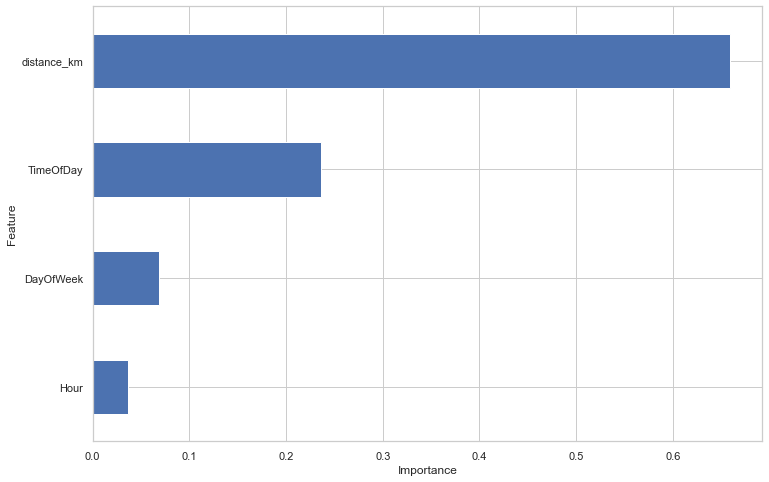

In [274]:
plt.figure(figsize=(12,8))
feat_imp.plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature");

### Neural Network

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD,Adam

In [275]:
!pip install protobuf==3.19.0

ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: tensorflow-metadata 1.13.1 has requirement protobuf<5,>=3.20.3, but you'll have protobuf 3.19.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: tensorflow-datasets 4.9.2 has requirement protobuf>=3.20, but you'll have protobuf 3.19.0 which is incompatible.
ERROR: googleapis-common-protos 1.59.0 has requirement protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you'll have protobuf 3.19.0 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\hp\\anaconda3\\Lib\\site-packages\\google\\~upb\\_message.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.0
    Uninstalling protobuf-4.23.0:
      Successfully uninstalled protobuf-4.23.0


ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: 'c:\\users\\hp\\anaconda3\\lib\\site-packages\\protobuf-4.23.0.dist-info\\METADATA'



In [3]:
df = pd.read_csv('nyc_clean.csv')

In [4]:
df

,trip_duration,distance_km,DayOfWeek,TimeOfDay
0,455.0,1.502172,Monday,Afternoon
1,663.0,1.808660,Sunday,Night
2,429.0,1.483632,Wednesday,Evening
3,435.0,1.187038,Saturday,Afternoon
4,443.0,1.099625,Saturday,Evening
...,...,...,...,...
1359256,778.0,1.227090,Friday,Afternoon
1359257,655.0,6.046212,Sunday,Morning
1359258,764.0,7.821532,Friday,Night
1359259,373.0,1.092524,Tuesday,Afternoon


In [14]:
target = 'trip_duration'
X = df.drop(columns = target)
y = df[target]

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359261 entries, 0 to 1458525
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   distance_km  1359261 non-null  float64
 1   Hour         1359261 non-null  int64  
 2   DayOfWeek    1359261 non-null  object 
 3   TimeOfDay    1359261 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 51.9+ MB


In [15]:
encoder = OneHotEncoder()
encoder.fit(X)

OneHotEncoder(cols=['DayOfWeek', 'TimeOfDay'])

In [16]:
X = encoder.transform(X)

In [17]:
X

,distance_km,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,TimeOfDay_1,TimeOfDay_2,TimeOfDay_3,TimeOfDay_4
0,1.502172,1,0,0,0,0,0,0,1,0,0,0
1,1.808660,0,1,0,0,0,0,0,0,1,0,0
2,1.483632,0,0,1,0,0,0,0,0,0,1,0
3,1.187038,0,0,0,1,0,0,0,1,0,0,0
4,1.099625,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1359256,1.227090,0,0,0,0,1,0,0,1,0,0,0
1359257,6.046212,0,1,0,0,0,0,0,0,0,0,1
1359258,7.821532,0,0,0,0,1,0,0,0,1,0,0
1359259,1.092524,0,0,0,0,0,0,1,1,0,0,0


In [18]:
minmax = MinMaxScaler()

In [19]:
minmax.fit_transform(X)

array([[0.04827898, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05812934, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.04768313, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.25137973, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.03511312, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03643506, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
X = minmax.fit_transform(X)

In [12]:
X = np.array(X)

In [22]:
X

array([[0.04827898, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05812934, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.04768313, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.25137973, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.03511312, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03643506, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [24]:
y = np.array(y)

In [25]:
y

array([455., 663., 429., ..., 764., 373., 198.])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [83]:
X_train.shape

(869926, 13)

In [87]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu')) 
#model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [103]:
learn_rate=.2
adam = Adam(lr=learn_rate, beta_1=0.8, beta_2=0.8, epsilon=None, decay=0.01, amsgrad=False)
sgd = SGD(lr=learn_rate,momentum=.5,decay=0.01)

C:\Users\hp\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [104]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001,min_delta=0.001)

In [105]:
model.compile(optimizer=adam, loss='mean_squared_logarithmic_error')

In [106]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=5,
                   min_delta=0.01,
                   restore_best_weights = True)

In [107]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs=30,
                    callbacks=[es,lr_reduction],
                    batch_size=50,
                    verbose=1)

Epoch 1/30
17399/17399 [==============================] - 67s 4ms/step - loss: 0.2189 - val_loss: 0.1936
Epoch 2/30
17399/17399 [==============================] - 64s 4ms/step - loss: 0.1904 - val_loss: 0.1887
Epoch 3/30
17399/17399 [==============================] - 65s 4ms/step - loss: 0.1883 - val_loss: 0.1863
Epoch 4/30
17399/17399 [==============================] - 65s 4ms/step - loss: 0.1848 - val_loss: 0.1841
Epoch 5/30
17399/17399 [==============================] - 66s 4ms/step - loss: 0.1846 - val_loss: 0.1833
Epoch 6/30
17399/17399 [==============================] - 65s 4ms/step - loss: 0.1846 - val_loss: 0.1819
Epoch 7/30
17399/17399 [==============================] - 78s 4ms/step - loss: 0.1829 - val_loss: 0.1816
Epoch 8/30
17399/17399 [==============================] - 74s 4ms/step - loss: 0.1824 - val_loss: 0.1804
Epoch 9/30
17399/17399 [==============================] - 99s 6ms/step - loss: 0.1830 - val_loss: 0.1806
Epoch 10/30
17399/17399 [==============================

In [122]:
train_pred =  model.predict(X_train)
val_pred =  model.predict(X_val)
test_pred = model.predict(X_test)

In [123]:
train_pred[train_pred<0] = 0
val_pred[val_pred<0] = 0
test_pred[test_pred<0] = 0

In [124]:
r2_train = r2_score(y_train, train_pred)
r2_val = r2_score(y_val, val_pred)
r2_test = r2_score(y_test, test_pred)

In [126]:
rmsle_train = np.sqrt(mean_squared_log_error(y_train, train_pred))
rmsle_val = np.sqrt(mean_squared_log_error(y_val, val_pred))
rsmle_test = np.sqrt(mean_squared_log_error(y_test, test_pred))

In [145]:
print("Neural Network Model Evaluation")
print('-------------------------------')
print("Training Accuracy:", round(r2_train, 4))
print("Validation Accuracy:", round(r2_val, 4))
print("Testing Accuracy:", round(r2_test, 4))
print("Training Error:", round(rmsle_train, 4))
print("Validation Error:", round(rmsle_val, 4))
print("Testing Error:", round(rsmle_test, 4))

Neural Network Model Evaluation
-------------------------------
Training Accuracy: 0.6279
Validation Accuracy: 0.6286
Testing Accuracy: 0.6286
Training Error: 0.4295
Validation Error: 0.4281
Testing Error: 0.4276


In [133]:
model.save("NN_final.h5")

In [134]:
nn = tf.keras.models.load_model('NN_final.h5')

### Random Forest Regression

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [61]:
rf_m = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, max_depth=15))

In [62]:
rf_m.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['DayOfWeek', 'TimeOfDay'])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor(max_depth=15))])

In [63]:
r2_train = r2_score(y_train, rf_m.predict(X_train))
r2_val = r2_score(y_val, rf_m.predict(X_val))
rmsle_train = np.sqrt(mean_squared_log_error(y_train, rf_m.predict(X_train)))
rmsle_val = np.sqrt(mean_squared_log_error(y_val, rf_m.predict(X_val)))

In [64]:
print("Random Forest Model Evaluation")
print('-------------------------------')
print("Training Accuracy:", round(r2_train, 4))
print("Validation Accuracy:", round(r2_val, 4))
print("Training Error:", round(rmsle_train, 4))
print("Validation Error:", round(rmsle_val, 4))

Random Forest Model Evaluation
-------------------------------
Training Accuracy: 0.6684
Validation Accuracy: 0.6399
Training Error: 0.4115
Validation Error: 0.4297


In [56]:
rf_m.named_steps["standardscaler"].

StandardScaler()